# Matchup satellite data to ship, glider, or animal tracks

In this tutorial you will extract PACE data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

### Datasets used:
- Leve 3 Chlorophyll-a from PACE version 3
- From CoastWatch tutorials: a loggerhead turtle telemetry track that has been subsample to reduce the data requests needed for this tutorial from over 1200 to 25. The turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. Its tag transmitted for over 3 years and went all the way to the Southern tip of Baja California. The track data can be downloaded from `data` folder in this project folder. 

## Import the required Python modules

In [71]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
warnings.filterwarnings('ignore')

## Load the track data into a pandas data frame


In [72]:
track_path = os.path.join('/home/jovyan/proj_2024_PACEToolkit',
                          'data',
                          'turtle_track.dat')

df = pd.read_csv(track_path, parse_dates=[['year', 'month', 'day']] )
df.mean_lon = df.mean_lon -180
print(df.head(2))

  year_month_day  mean_lon   mean_lat
0     2024-05-04 -3.380567  32.678728
1     2024-06-23 -4.139105  35.057734


## Plot the track on a map

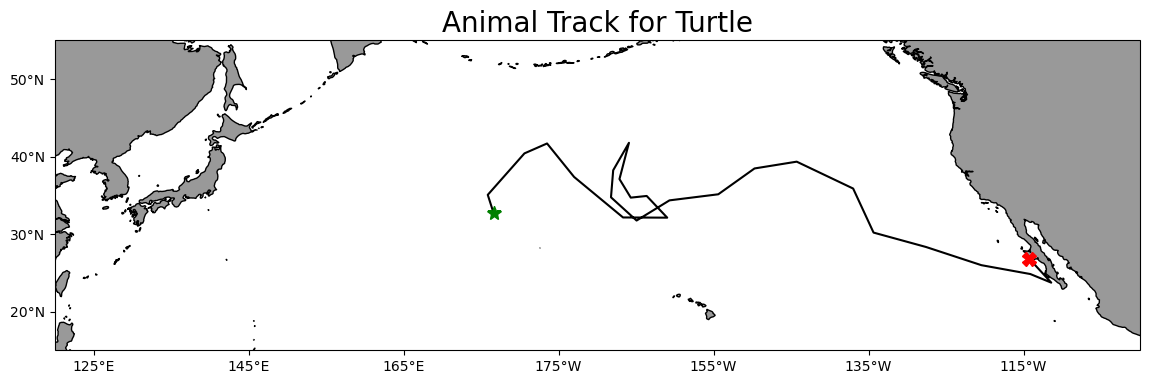

In [40]:
plt.figure(figsize=(14, 10))
crs = ccrs.PlateCarree(central_longitude=180)
# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=crs)

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120-180, 260-180, 15, 55], crs)

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(125-180, 255-180, 20), crs=crs)
ax1.set_yticks(range(20, 60, 10), crs=crs)

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df.mean_lon.to_numpy(), df.mean_lat.to_numpy()
ax1 = plt.plot(x, y, transform=crs, color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=crs,
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=crs,
               markersize=10)
plt.title('Animal Track for Turtle', fontsize=20)

plt.show()

## Extract PACE data corresponding to points on the track

We will use the Level-3 mapped (gridded) Chl-a data product. Short Name: [PACE_OCI_L3M_CHL_NRT](https://cmr.earthdata.nasa.gov/search/concepts/C3020923919-OB_CLOUD.html)

In [73]:
import earthaccess
auth = earthaccess.login(persist=True)

Set up the date that we want. The bounding box does not matter since these data are global and a single file for the whole globe.

In [74]:
i = 0
tspan = (df.year_month_day[0], df.year_month_day[0])

Search for the granuales (files) needed for each point.

In [75]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan
)

In [53]:
# There are 9 Chl-a products: Day, 8-day, and month and 3 spatial resolution.
len(results)

9

In [59]:
# We can look at the urls
[result.data_links() for result in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240430_20240507.L3m.8D.CHL.V2_0.chlor_a.1deg.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240430_20240507.L3m.8D.CHL.V2_0.chlor_a.0p1deg.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240430_20240507.L3m.8D.CHL.V2_0.chlor_a.4km.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.CHL.V2_0.chlor_a.1deg.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.CHL.V2_0.chlor_a.0p1deg.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240501_20240531.L3m.MO.CHL.V2_0.chlor_a.4km.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240504.L3m.DAY.CHL.V2_0.chlor_a.0p1deg.NRT.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-pr

In [76]:
# This helps us see that we need to filter; this gets us the one file we want
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan, 
    granule_name="*.DAY*.4km*"
)

In [77]:
results[0]

Collection: {'ShortName': 'PACE_OCI_L3M_CHL_NRT', 'Version': '2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-05-04T23:59:59Z', 'BeginningDateTime': '2024-05-04T00:00:00Z'}}
Size(MB): 12.162630081176758
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240504.L3m.DAY.CHL.V2_0.chlor_a.4km.NRT.nc']

## Get the Chl-a value for the lat, lon

In [78]:
paths = earthaccess.open(results)
ds = xr.open_dataset(paths[0])
ds

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 149MB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 149MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240504.L3m.DAY.CHL.V2_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/2.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3300524
    data_minimum:                      0.006873704
    data_maximum:                      99.78542

In [88]:
# The value might be an NA
ds_i = ds.sel(lat=df.mean_lat[i], lon=df.mean_lon[i], method='nearest')

### Consolidate the downloaded satellite data into the track data frame

In [108]:
df.loc[i]

year_month_day    2024-05-04 00:00:00
mean_lon                    -3.380567
mean_lat                    32.678728
Name: 0, dtype: object

In [109]:
data = [{'date': df.loc[i]['year_month_day'], 'lat': df.loc[i]['mean_lat'], 'lon': df.loc[i]['mean_lon'], 'matched_lat': ds_i.lat.values, 'matched_lon': ds_i.lon.values, 'matched_chla': ds_i.chlor_a.values}]
df_i = pd.DataFrame(data)
df_i

,date,lat,lon,matched_lat,matched_lon,matched_chla
0,2024-05-04,32.678728,-3.380567,32.6875,-3.395828,nan


## Run a loop to get all the data

### Save your work

In [10]:
df_all.to_csv('chl_matchup.csv', index=False, encoding='utf-8')

## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.06 0.71


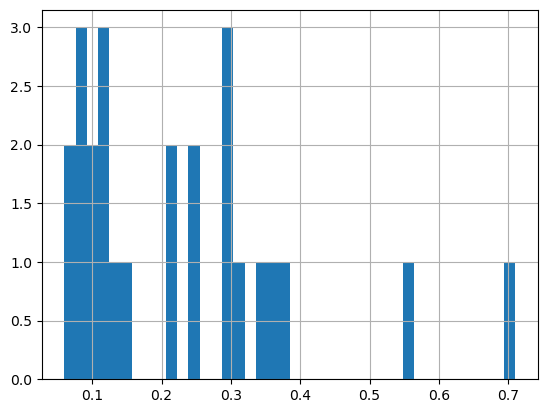

In [11]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values and a few very high values. Using a  linear color bar,  most of the lower values would have the same color.
* To better visualize the data, we often plot the log or log10 of chlorophyll. 

### Plot a histogram of the log of the chlorophyll data

Range: -2.8134108 -0.34249032


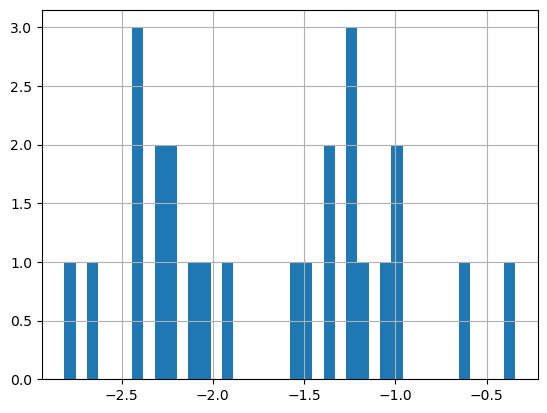

In [12]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The logarithmic transformation displays the range of values across the color bar range (above). 

### Map the chlorophyll data

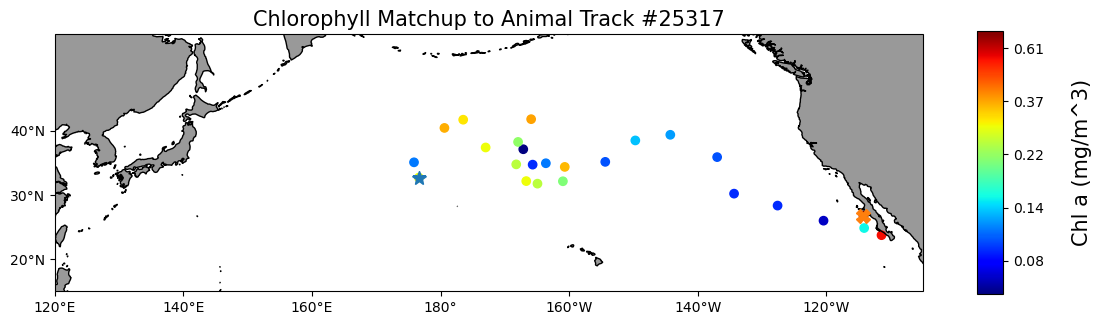

In [13]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120,255, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(120,255,20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20,50,10), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df.mean_lon),list(df.mean_lat)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Animal Track", size=15)
plt.show()